In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
from scipy.stats import wilcoxon as wilcoxon

In [2]:
path = 'Data'

with open(path + '/continuous_full_data_block1.pickle', 'rb') as handle:
    refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)

with open(path + '/continuous_full_data_block2.pickle', 'rb') as handle:
    refs_block2, poss_block2, dec_vels_block2, int_vel_block2, emgs_block2, Ws_block2, Hs_block2, alphas_block2, pDs_block2, times_block2, conditions_block2 = pickle.load(handle)

keys = ['METACPHS_S106', 'METACPHS_S107','METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112', 'METACPHS_S113', 'METACPHS_S114', 'METACPHS_S115', 'METACPHS_S116', 'METACPHS_S117', 'METACPHS_S118', 'METACPHS_S119']

In [3]:
update_ix = np.load(r"Data\update_ix.npy")
lb = update_ix[11]
ub = update_ix[12]

subj = keys[0]
c = 3

ref = refs_block2[subj][c, :][lb:ub, :]
pos = poss_block2[subj][c, :][lb:ub, :]
emg = emgs_block2[subj][c, :][lb:ub, :]
Ds = Ws_block2[subj][c, :][lb:ub, :, :]
vel_int = int_vel_block2[subj][c, :][lb:ub, :]
vel_dec = dec_vels_block2[subj][c, :][lb:ub, :]

print(f"ref.shape: {ref.shape}")
print(f"pos.shape: {pos.shape}")
print(f"emg.shape: {emg.shape}")
print(f"vel_int.shape: {vel_int.shape}")
print(f"vel_dec.shape: {vel_dec.shape}")
print(f"Ds.shape: {Ds.shape}")

ref.shape: (1202, 2)
pos.shape: (1202, 2)
emg.shape: (1202, 64)
vel_int.shape: (1202, 2)
vel_dec.shape: (1202, 2)
Ds.shape: (1202, 2, 64)


In [4]:
n_time, n_dim = pos.shape
print("(n_time, n_dim)")
print(pos.shape)

(n_time, n_dim)
(1202, 2)


In [5]:
# This code is for reference so just pass over it
if False:
    s_temp = self.training_data[lower_bound:upper_bound,:]
    if self.normalize_EMG:
        s_normed = s_temp/np.amax(s_temp)
    else:
        s_normed = s_temp
    if self.PCA_comps!=self.pca_channel_default:  
        pca = PCA(n_components=self.PCA_comps)
        s_normed = pca.fit_transform(s_normed)
    s = np.transpose(s_normed)
    v_actual = self.w@s
    p_actual = np.cumsum(v_actual, axis=1)*self.dt  # Numerical integration of v_actual to get p_actual
    p_reference = np.transpose(self.labels[lower_bound:upper_bound,:])
    self.F = s[:,:-1] # note: truncate F for estimate_decoder
    self.V = (p_reference - p_actual)*self.dt
    if self.global_method=='APFL':
        self.Vglobal = (p_reference - np.cumsum(self.global_w@s, axis=1)*self.dt)*self.dt
        self.Vmixed = (p_reference - np.cumsum(self.mixed_w@s, axis=1)*self.dt)*self.dt

In [6]:
def calculate_intended_vels(ref, pos, fs):
    '''
    ref = 1 x 2
    pos = 1 x 2
    fs = scalar
    '''
    
    gain = 120
    ALMOST_ZERO_TOL = 0.01
    intended_vector = (ref - pos)/fs
    if np.linalg.norm(intended_vector) <= ALMOST_ZERO_TOL:
        intended_norm = np.zeros((2,))
    else:
        intended_norm = intended_vector * gain
    return intended_norm
    

In [7]:
def reconstruct_trial(ref_tr, emg_tr, Ds_tr, time_x, fs = 60):
    time_x = time_x
    vel_est = np.zeros_like((ref_tr))
    pos_est = np.zeros_like((ref_tr))
    int_vel_est = np.zeros_like((ref_tr))

    hit_bound = 0
    vel_est[0] = Ds[0]@emg_tr[0] 
    pos_est[0] = [0, 0]
    for tt in range(1, time_x):
        vel_plus = Ds[tt-1]@emg_tr[tt] # at time tt
        p_plus = pos_est[tt-1, :] + (vel_est[tt-1, :]/fs)
        # x-coordinate
        if abs(p_plus[0]) > 36:
            p_plus[0] = pos_est[tt-1, 0]
            vel_plus[0] = 0
            hit_bound = hit_bound + 1 # update hit_bound counter
        if abs(p_plus[1]) > 24:
            p_plus[1] = pos_est[tt-1, 1]
            vel_plus[1] = 0
            hit_bound = hit_bound + 1 # update hit_bound counter
        if hit_bound > 200:
            p_plus[0] = 0
            vel_plus[0] = 0
            p_plus[1] = 0
            vel_plus[1] = 0
            hit_bound = 0
        # now update velocity and position
        vel_est[tt] = vel_plus
        pos_est[tt] = p_plus
        # calculate intended velocity
        int_vel_est[tt] = calculate_intended_vels(ref_tr[tt], p_plus, 60)
    return vel_est, pos_est, int_vel_est

In [8]:
def reconstruct_trial_fixed_decoder(ref_tr, emg_tr, Ds_fixed, time_x, fs = 60):
    time_x = time_x
    vel_est = np.zeros_like((ref_tr))
    pos_est = np.zeros_like((ref_tr))
    int_vel_est = np.zeros_like((ref_tr))

    hit_bound = 0
    vel_est[0] = Ds_fixed@emg_tr[0]  # D@s --> Kai's v_actual
    pos_est[0] = [0, 0]
    for tt in range(1, time_x):
        vel_plus = Ds_fixed@emg_tr[tt] # at time tt --> also Kai's v_actual...
        p_plus = pos_est[tt-1, :] + (vel_est[tt-1, :]/fs)
        # These are just correctives, such that vel_plus can get bounded
        # x-coordinate
        if abs(p_plus[0]) > 36:
            p_plus[0] = pos_est[tt-1, 0]
            vel_plus[0] = 0
            hit_bound = hit_bound + 1 # update hit_bound counter
        if abs(p_plus[1]) > 24:
            p_plus[1] = pos_est[tt-1, 1]
            vel_plus[1] = 0
            hit_bound = hit_bound + 1 # update hit_bound counter
        if hit_bound > 200:
            p_plus[0] = 0
            vel_plus[0] = 0
            p_plus[1] = 0
            vel_plus[1] = 0
            hit_bound = 0
        # now update velocity and position
        vel_est[tt] = vel_plus
        pos_est[tt] = p_plus
        # calculate intended velocity
        int_vel_est[tt] = calculate_intended_vels(ref_tr[tt], p_plus, 60)
    return vel_est, pos_est, int_vel_est

In [9]:
time_x = n_time
print(time_x)
(vel_est, pos_est, int_vel_est) = reconstruct_trial(ref, emg, Ds, time_x, fs = 60)

1202


In [10]:
# true, true means that the error in estimation is 0

# position estimation
print(np.allclose(pos_est[:time_x, 0] - pos[:time_x, 0], 0))
print(np.allclose(pos_est[:time_x, 1] - pos[:time_x, 1], 0))

# intended velocity estimation
print(np.allclose(int_vel_est[:time_x, 0] - vel_int[:time_x, 0], 0))
print(np.allclose(int_vel_est[:time_x, 1] - vel_int[:time_x, 1], 0))


False
False
False
False


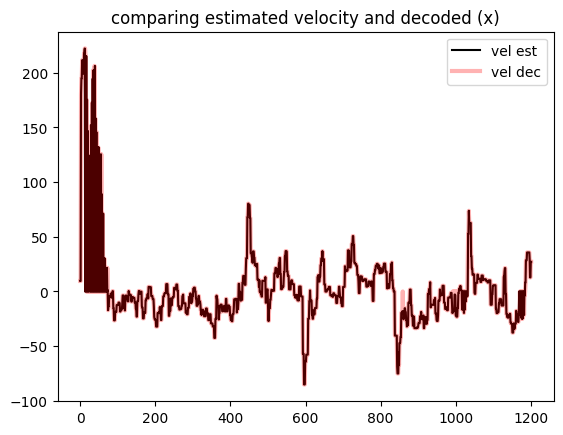

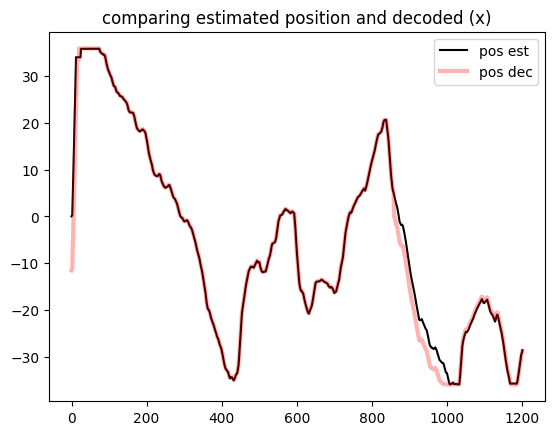

False

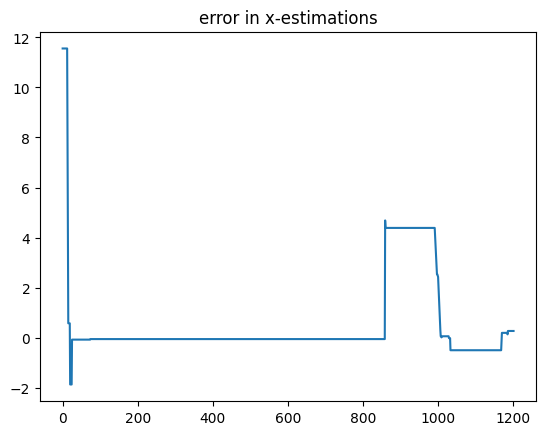

In [11]:
red_alpha = 0.3

plt.plot(vel_est[:time_x, 0], '-', label = "vel est", color = 'black')
plt.plot(vel_dec[:time_x, 0], lw = 3, label = "vel dec", alpha = red_alpha, color = 'red')
plt.legend()
plt.title("comparing estimated velocity and decoded (x)")
plt.show()

plt.plot(pos_est[:time_x, 0], '-', label = "pos est", color = 'black')
plt.plot(pos[:time_x, 0], lw = 3, label = "pos dec", alpha = red_alpha, color = 'red')
plt.legend()
plt.title("comparing estimated position and decoded (x)")
plt.show()

plt.plot(pos_est[:time_x, 0] - pos[:time_x, 0])
plt.title("error in x-estimations")

np.allclose(pos_est[:time_x, 0] - pos[:time_x, 0], 0)

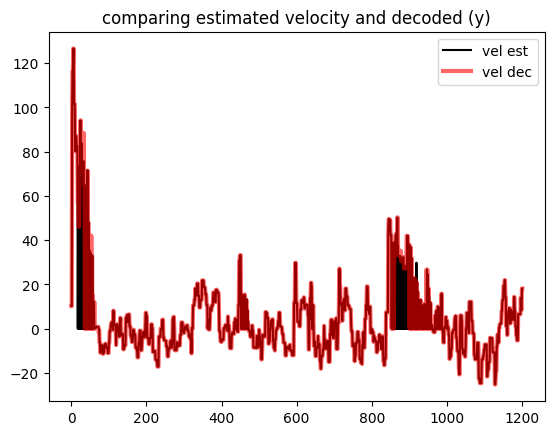

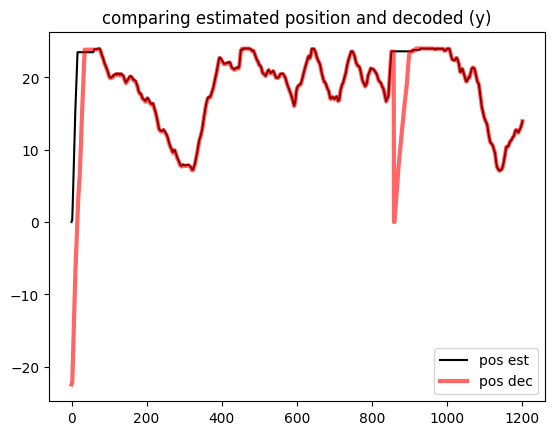

Text(0.5, 1.0, 'error in y-estimations')

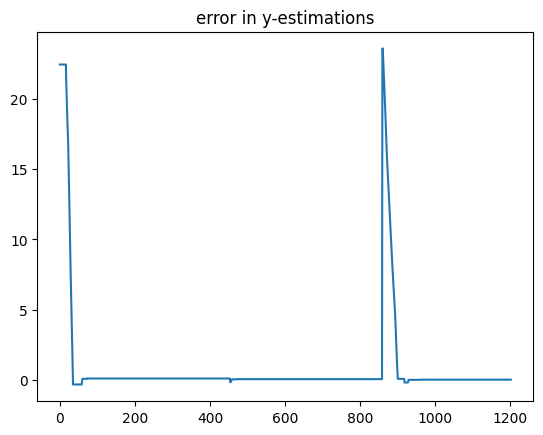

In [12]:
plt.plot(vel_est[:time_x, 1], '-', label = "vel est", color = 'black')
plt.plot(vel_dec[:time_x, 1], lw = 3, label = "vel dec", alpha = 0.6, color = 'red')
plt.legend()
plt.title("comparing estimated velocity and decoded (y)")
plt.show()

plt.plot(pos_est[:time_x, 1], '-', label = "pos est", color = 'black')
plt.plot(pos[:time_x, 1], lw = 3, label = "pos dec", alpha = 0.6, color = 'red')
plt.legend()
plt.title("comparing estimated position and decoded (y)")
plt.show()


plt.plot(pos_est[:time_x, 1] - pos[:time_x, 1])
plt.title("error in y-estimations")

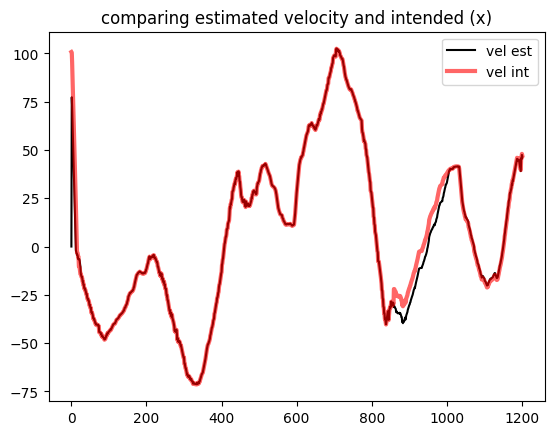

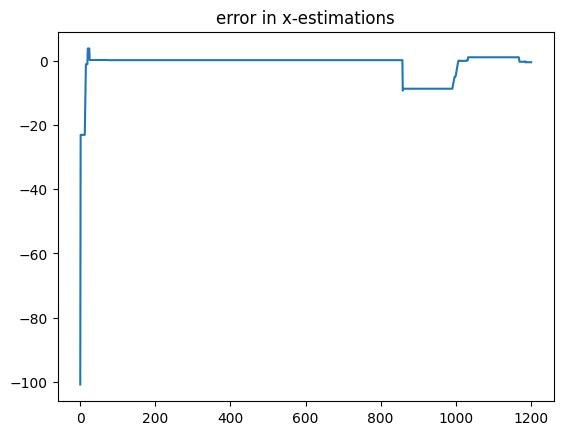

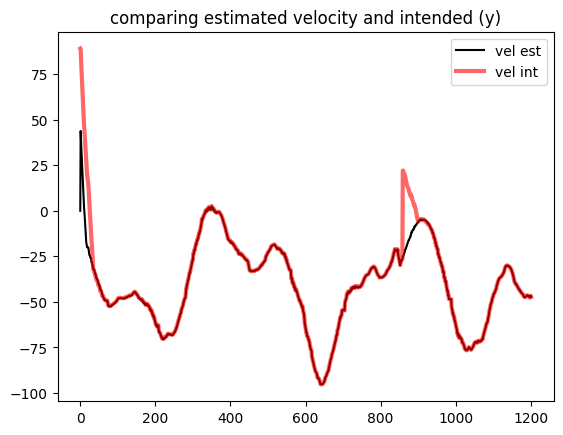

Text(0.5, 1.0, 'error in y-estimations')

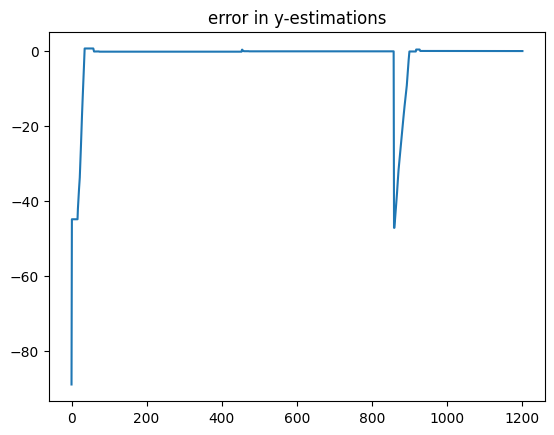

In [13]:
plt.plot(int_vel_est[:time_x, 0], '-', label = "vel est", color = 'black')
plt.plot(vel_int[:time_x, 0], lw = 3, label = "vel int", alpha = 0.6, color = 'red')
plt.legend()
plt.title("comparing estimated velocity and intended (x)")
plt.show()


plt.plot(int_vel_est[:time_x, 0] - vel_int[:time_x, 0])
plt.title("error in x-estimations")
plt.show()

plt.plot(int_vel_est[:time_x, 1], '-', label = "vel est", color = 'black')
plt.plot(vel_int[:time_x, 1], lw = 3, label = "vel int", alpha = 0.6, color = 'red')
plt.legend()
plt.title("comparing estimated velocity and intended (y)")
plt.show()


plt.plot(int_vel_est[:time_x, 1] - vel_int[:time_x, 1])
plt.title("error in y-estimations")

## fixed decoder

In [14]:
subj = keys[0]
c = 3
ref = refs_block1[subj][c, :]
pos = poss_block1[subj][c, :]
emg = emgs_block1[subj][c, :]
Ds = Ws_block1[subj][c, :]
vel_int = int_vel_block1[subj][c, :]
vel_dec = dec_vels_block1[subj][c, :]

n_time, n_dim = pos.shape

In [15]:
Ds[-1].shape

(2, 64)

In [16]:
Dfix = Ds[-1]
time_x = n_time
(vel_fixed, pos_fixed, int_vel_fixed) = reconstruct_trial_fixed_decoder(ref, emg, Dfix, time_x, fs = 60)

In [17]:
pos_est.shape

(1202, 2)

In [18]:
pos.shape

(20770, 2)

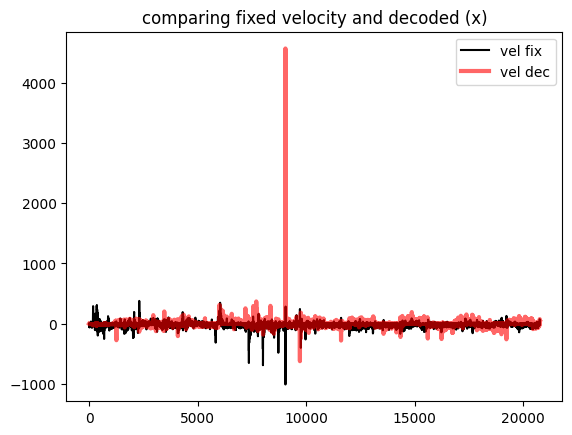

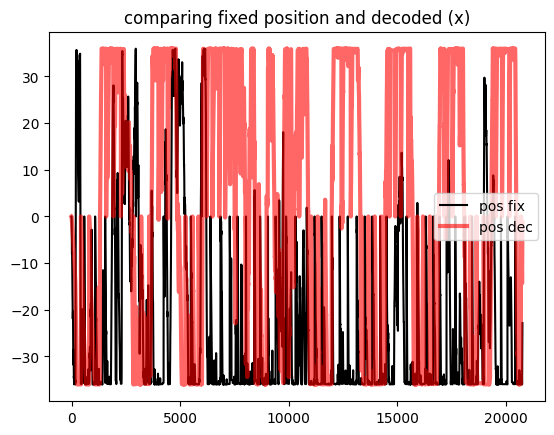

False

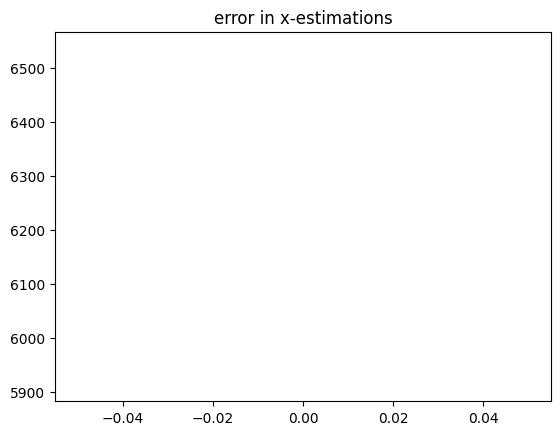

In [19]:
plt.plot(vel_fixed[:time_x, 0], '-', label = "vel fix", color = 'black')
plt.plot(vel_dec[:time_x, 0], lw = 3, label = "vel dec", alpha = 0.6, color = 'red')
plt.legend()
plt.title("comparing fixed velocity and decoded (x)")
plt.show()

plt.plot(pos_fixed[:time_x, 0], '-', label = "pos fix", color = 'black')
plt.plot(pos[:time_x, 0], lw = 3, label = "pos dec", alpha = 0.6, color = 'red')
plt.legend()
plt.title("comparing fixed position and decoded (x)")
plt.show()

plt.plot(np.linalg.norm(pos_fixed[:time_x, 0] - pos[:time_x, 0], axis=0))
plt.title("error in x-estimations")

#np.allclose(pos_est[:time_x, 0] - pos[:time_x, 0], 0)
#^ Assuming that was supposed to be pos_fixed and not pos_est
np.allclose(pos_fixed[:time_x, 0] - pos[:time_x, 0], 0)

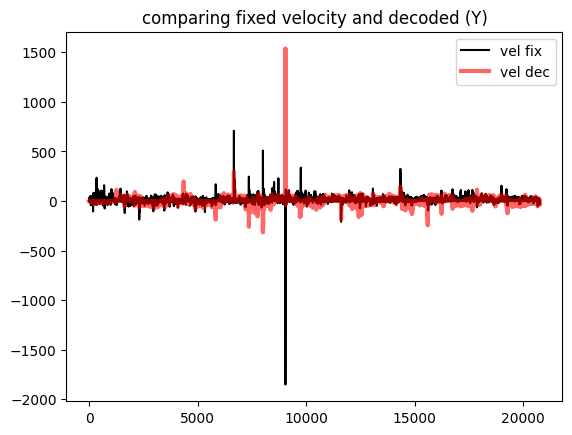

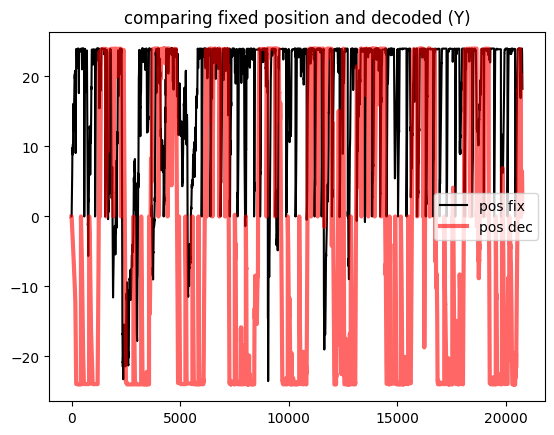

False

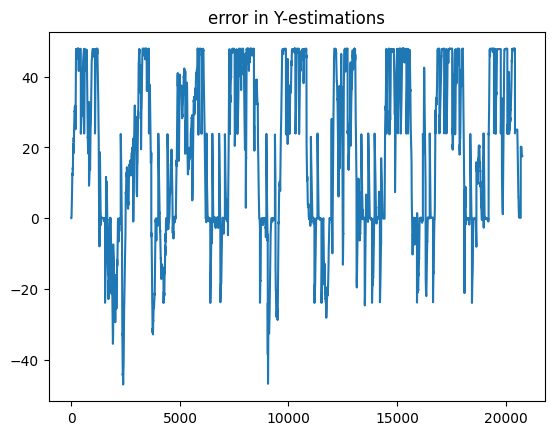

In [20]:
plt.plot(vel_fixed[:time_x, 1], '-', label = "vel fix", color = 'black')
plt.plot(vel_dec[:time_x, 1], lw = 3, label = "vel dec", alpha = 0.6, color = 'red')
plt.legend()
plt.title("comparing fixed velocity and decoded (Y)")
plt.show()

plt.plot(pos_fixed[:time_x, 1], '-', label = "pos fix", color = 'black')
plt.plot(pos[:time_x, 1], lw = 3, label = "pos dec", alpha = 0.6, color = 'red')
plt.legend()
plt.title("comparing fixed position and decoded (Y)")
plt.show()

plt.plot(pos_fixed[:time_x, 1] - pos[:time_x, 1])
plt.title("error in Y-estimations")

#np.allclose(pos_est[:time_x, 1] - pos[:time_x, 1], 0)
np.allclose(pos_fixed[:time_x, 0] - pos[:time_x, 0], 0)

Text(0, 0.5, 'norm')

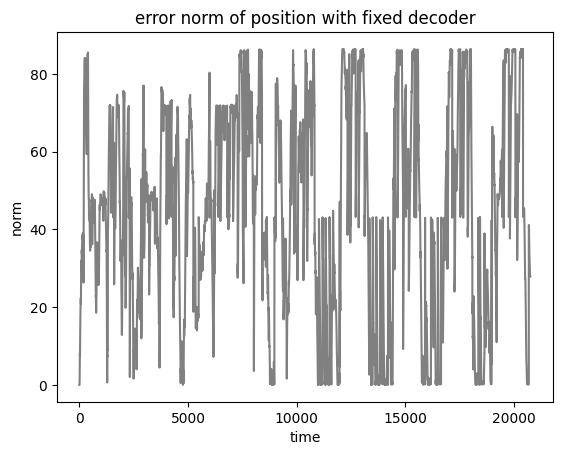

In [21]:
# error norm

plt.plot(np.linalg.norm(pos_fixed[:time_x, :] - pos[:time_x, :], axis = 1), color = 'gray')
plt.title("error norm of position with fixed decoder")
plt.xlabel("time")
plt.ylabel("norm")

Checking each update this time

In [22]:
for i in range(len(update_ix)-1):
    lb = update_ix[i]
    ub = update_ix[i+1]
    ref = refs_block2[subj][c, :][lb:ub, :]
    pos = poss_block2[subj][c, :][lb:ub, :]
    emg = emgs_block2[subj][c, :][lb:ub, :]
    Ds = Ws_block2[subj][c, :][lb:ub, :, :]
    vel_int = int_vel_block2[subj][c, :][lb:ub, :]
    vel_dec = dec_vels_block2[subj][c, :][lb:ub, :]
    
    n_time, n_dim = pos.shape
    time_x = n_time
    print(time_x)
    (vel_est, pos_est, int_vel_est) = reconstruct_trial(ref, emg, Ds, time_x, fs = 60)

    # position estimation
    print(np.allclose(pos_est[:time_x, 0] - pos[:time_x, 0], 0))
    print(np.allclose(pos_est[:time_x, 1] - pos[:time_x, 1], 0))
    # intended velocity estimation
    print(np.allclose(int_vel_est[:time_x, 0] - vel_int[:time_x, 0], 0))
    print(np.allclose(int_vel_est[:time_x, 1] - vel_int[:time_x, 1], 0))
    print()

1200
True
True
True
True

1202
False
False
False
False

1202
False
False
False
False

1202
False
False
False
False

1202
False
False
False
False

1202
False
False
False
False

1202
False
False
False
False

1202
False
False
False
False

1202
False
False
False
False

1202
False
False
False
False

1202
False
False
False
False

1202
False
False
False
False

1202
False
False
False
False

1202
False
False
False
False

1202
False
False
False
False

1202
False
False
False
False

1202
False
False
False
False

337
False
False
False
False

